In [1]:
from utils.imports import *

Using TensorFlow backend.


In [ ]:
def load_train():
    folders = [x for x in os.listdir(data_path) if 'subset' in x]
    os.chdir(data_path)
    patients = []    
    for i in folders:
        os.chdir(data_path + i)
        patient_ids = [x for x in os.listdir(data_path + i) if '.mhd' in x]
        for id in patient_ids:
            j = '{}/{}'.format(i, id)
            patients.append(j)
    return patients

def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return(f)
        
def make_mask(center,diam,z,width,height,spacing,origin): #只显示结节
    '''
Center : 圆的中心 px -- list of coordinates x,y,z
diam : 圆的直径 px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image

def get_segmented_lungs(im, plot=False):
    # Step 1: Convert into a binary image.
    binary = im < -400
    # Step 2: Remove the blobs connected to the border of the image.
    cleared = clear_border(binary)
    # Step 3: Label the image.
    label_image = label(cleared)
    # Step 4: Keep the labels with 2 largest areas.
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    # Step 5: Erosion operation with a disk of radius 2. This operation is seperate the lung nodules attached to the blood vessels.
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    # Step 6: Closure operation with a disk of radius 10. This operation is    to keep nodules attached to the lung wall.
    selem = disk(10) # CHANGE BACK TO 10
    binary = binary_closing(binary, selem)
    # Step 7: Fill in the small holes inside the binary mask of lungs.
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    # Step 8: Superimpose the binary mask on the input image.
    get_high_vals = binary == 0
    im[get_high_vals] = -2000
    return im, binary

In [ ]:
def create_samples(img_file):
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    if mini_df.shape[0]>0: # some files may not have a nodule--skipping those 
        # load the data once
        patient_id = img_file.split('/')[-1][:-4]
        itk_img = SimpleITK.ReadImage(data_path + img_file) 
        img_array = SimpleITK.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
        num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
        # go through all nodes (why just the biggest?)
        for node_idx, cur_row in mini_df.iterrows():       
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam = cur_row["diameter_mm"]
            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint(np.absolute(center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            
            imgs = np.ndarray([3,height,width],dtype=np.float32)
            masks = np.ndarray([3,height,width],dtype=np.uint8)
            overlaps = np.ndarray([3,height,width],dtype=np.uint8)
            
            for i, i_z in enumerate(np.arange(int(v_center[2])-1,
                             int(v_center[2])+2).clip(0, num_z-1)): # clip prevents going out of bounds in Z
                img = img_array[i_z]
                seg_img, overlap = helpers.get_segmented_lungs(img.copy())
                mask = make_mask(center, diam, i_z*spacing[2]+origin[2],
                                 width, height, spacing, origin)
                masks[i] = mask
                overlaps[i] = overlap
                imgs[i] = img_array[i_z]
            np.save(os.path.join(pic_path,"images_%s_%04d.npy" % (patient_id, node_idx)),imgs)
            np.save(os.path.join(pic_path,"masks_%s_%04d.npy" % (patient_id, node_idx)),masks)
            np.save(os.path.join(pic_path,"lungmask_%s_%04d.npy" % (patient_id, node_idx)),overlaps)

### Train

In [2]:
data_path = PATH['src_train']
pic_path = PATH['pic_val']
csv_path = PATH['annotations_train']
generated_path = PATH['generated_train']

In [ ]:
patients = load_train()
df_node = pd.read_csv(csv_path+"annotations.csv")
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(patients, file_name))
df_node = df_node.dropna()

In [ ]:
Parallel(n_jobs=-1)(delayed(create_samples)(patient) for patient in tqdm(sorted(patients)))

### 合并

In [11]:
file_list=glob.glob(pic_path+"lungmask_*.npy")
out_images = []      #final set of images
out_nodemasks = []   #final set of nodemasks
for fname in tqdm(file_list):
    imgs_to_process = np.load(fname.replace("lungmask","images"))
    masks = np.load(fname)
    node_masks = np.load(fname.replace("lungmask","masks"))
    for i in range(len(imgs_to_process)):
        mask = masks[i]
        node_mask = node_masks[i]
        img = imgs_to_process[i]
        new_size = [512,512]   # we're scaling back up to the original size of the image
        img= mask*img          # apply lung mask
        #
        # renormalizing the masked image (in the mask region)
        #
        new_mean = np.mean(img[mask>0])  
        new_std = np.std(img[mask>0])
        #
        #  Pulling the background color up to the lower end
        #  of the pixel range for the lungs
        #
        old_min = np.min(img)       # background color
        img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
        img = img-new_mean
        img = img/new_std
        #make image bounding box  (min row, min col, max row, max col)
        labels = measure.label(mask)
        regions = measure.regionprops(labels)
        #
        # Finding the global min and max row over all regions
        #
        min_row = 512
        max_row = 0
        min_col = 512
        max_col = 0
        for prop in regions:
            B = prop.bbox
            if min_row > B[0]:
                min_row = B[0]
            if min_col > B[1]:
                min_col = B[1]
            if max_row < B[2]:
                max_row = B[2]
            if max_col < B[3]:
                max_col = B[3]
        width = max_col-min_col
        height = max_row - min_row
        if width > height:
            max_row=min_row+width
        else:
            max_col = min_col+height
        # 
        # cropping the image down to the bounding box for all regions
        # (there's probably an skimage command that can do this in one line)
        # 
        img = img[min_row:max_row,min_col:max_col]
        mask =  mask[min_row:max_row,min_col:max_col]
        if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
            pass
        else:
            # moving range to -1 to 1 to accomodate the resize function
            mean = np.mean(img)
            img = img - mean
            min = np.min(img)
            max = np.max(img)
            img = img/(max-min)
            new_img = resize(img,[512,512])
            new_node_mask = resize(node_mask[min_row:max_row,min_col:max_col],[512,512])
            out_images.append((new_img+1)*255)
            out_nodemasks.append((new_node_mask+1)*255)

num_images = len(out_images)
#
#  Writing out images and masks as 1 channel arrays for input into network
#
final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
for i in range(num_images):
    final_images[i,0] = out_images[i]
    final_masks[i,0] = out_nodemasks[i]

rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.2*num_images)
np.save(pic_path+"trainImages.npy",final_images[rand_i[test_i:]])
np.save(pic_path+"trainMasks.npy",final_masks[rand_i[test_i:]])
np.save(pic_path+"testImages.npy",final_images[rand_i[:test_i]])
np.save(pic_path+"testMasks.npy",final_masks[rand_i[:test_i]])

100%|██████████| 975/975 [01:47<00:00, 10.04it/s]


In [12]:
out_images[0].shape

(512, 512)

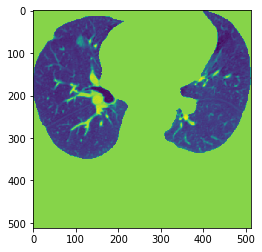

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(out_images[0])

([array([   0.,    0.,    4.,    1.,    1.,    1.,    0.,  505.,    0.,    0.]),
  array([   0.,    4.,    1.,    1.,    1.,    4.,    0.,    3.,  498.,    0.]),
  array([   0.,    8.,    2.,    0.,    1.,    1.,    0.,    5.,  495.,    0.]),
  array([   0.,    9.,    2.,    2.,    1.,    0.,    1.,    2.,  495.,    0.]),
  array([   0.,    6.,    6.,    1.,    1.,    6.,    1.,    2.,  489.,    0.]),
  array([   0.,    9.,    9.,    0.,    1.,    0.,    1.,    2.,  490.,    0.]),
  array([   0.,    7.,   10.,    1.,    4.,    0.,    2.,    3.,  485.,    0.]),
  array([   0.,   13.,    8.,    0.,    2.,    0.,    2.,    3.,  484.,    0.]),
  array([   0.,   15.,    9.,    0.,    0.,    2.,    0.,    2.,  484.,    0.]),
  array([   0.,   16.,    6.,    2.,    4.,    1.,    1.,    3.,  479.,    0.]),
  array([   0.,   17.,    9.,    1.,    1.,    1.,    3.,    4.,  476.,    0.]),
  array([   0.,   19.,   11.,    0.,    1.,    1.,    0.,    4.,  476.,    0.]),
  array([   0.,   26.,    3.

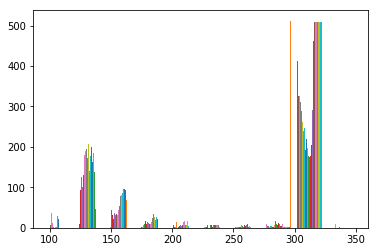

In [14]:
plt.hist(out_images[0].tolist())